## Data Cleaning

In [205]:
import os
import json
import warnings
import numpy as np
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.multioutput import MultiOutputRegressor
import optuna

warnings.filterwarnings("ignore")


In [206]:
# read data from numeric and nlp, then concat
num_df = pd.read_csv("data.csv")
nlp_df = pd.read_csv("nlp.csv")
num_df['date'] = pd.to_datetime(num_df['date'])
nlp_df['date'] = pd.to_datetime(nlp_df['date'])
data_df = pd.merge(num_df, nlp_df, on='date', how='inner')  # inner表示只保留在num_df和nlp_df中都有的日期
data_df = data_df[[col for col in data_df.columns if col not in ['WTI_price', 'Dubai_price', 'Brent_price']] + ['WTI_price', 'Dubai_price', 'Brent_price']]

# 資料清洗、補值
data_df['date'] = data_df['date'].dt.strftime('%Y%m%d').astype(float)
data_df = data_df.fillna(data_df.mean())

data_df.columns

Index(['date', 'WTI_export', 'Dubai_export', 'Brent_export', 'Unknown_export',
       'exchange rate', 'WTI_change', 'Dubai_change', 'Brent_change',
       'US Dollar Indicator', 'neg', 'neu', 'pos', 'compound', 'Topic 1',
       'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7',
       'Topic 8', 'Topic 9', 'Topic 10', 'WTI_price', 'Dubai_price',
       'Brent_price'],
      dtype='object')

## Feature Engineering

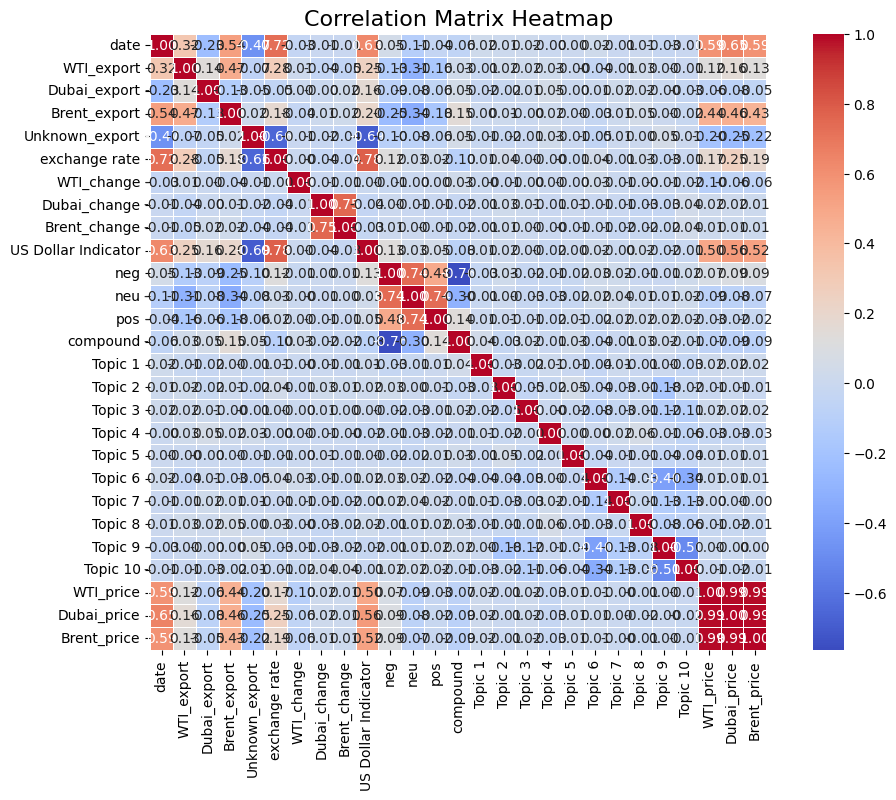

date                   float64
WTI_export             float64
Dubai_export           float64
Brent_export           float64
Unknown_export         float64
exchange rate          float64
WTI_change             float64
Dubai_change           float64
Brent_change           float64
US Dollar Indicator    float64
neg                    float64
neu                    float64
pos                    float64
compound               float64
Topic 1                float64
Topic 2                float64
Topic 3                float64
Topic 4                float64
Topic 5                float64
Topic 6                float64
Topic 7                float64
Topic 8                float64
Topic 9                float64
Topic 10               float64
WTI_price              float64
Dubai_price            float64
Brent_price            float64
dtype: object

In [214]:
########## 特徵工程 #########
correlation_matrix = data_df.corr()
plt.figure(figsize=(12, 8))  # 設置畫布大小
sns.heatmap(correlation_matrix, 
            annot=True,  # 在每個格子中顯示數值
            fmt=".2f",   # 數值格式保留兩位小數
            cmap="coolwarm",  # 配色方案
            square=True,  # 格子正方形
            linewidths=0.5)  # 格子邊框寬度
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.show()


data_df.dtypes

In [215]:
# train, valid, test split
train_df = data_df[data_df['date'] < 20240401]
valid_df = data_df[(data_df['date'] >= 20240401) & (data_df['date'] <= 20240630)]
test_df = data_df[data_df['date'] > 20240630]


features = train_df.columns[:-3]
target = train_df.columns[-3:]
X_train = train_df[features]
y_train = train_df[target]
X_valid = valid_df[features]
y_valid = valid_df[target]
X_test = test_df[features]
y_test = test_df[target]


test_df

,date,WTI_export,Dubai_export,Brent_export,Unknown_export,exchange rate,WTI_change,Dubai_change,Brent_change,US Dollar Indicator,...,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,WTI_price,Dubai_price,Brent_price
1643,20240701.0,40695.340000,3584.600000,2854.970000,268.830000,32.55,0.74,0.17,-0.26,105.90000,...,0.000806,0.000806,0.000807,0.000806,0.000806,0.736524,0.257024,84.70,88.21,86.57
1644,20240702.0,40695.340000,3584.600000,2854.970000,268.830000,32.63,-0.72,-0.29,1.98,105.72000,...,0.000699,0.000699,0.399478,0.000699,0.000699,0.000699,0.594927,84.09,87.95,88.28
1645,20240703.0,40695.340000,3584.600000,2854.970000,268.830000,32.63,1.31,0.68,-0.03,105.40000,...,0.000680,0.000680,0.000680,0.000680,0.000680,0.193422,0.801135,85.19,88.55,88.25
1646,20240704.0,40695.340000,3584.600000,2854.970000,268.830000,32.48,-0.43,0.56,0.10,105.13000,...,0.000588,0.000588,0.000588,0.000588,0.000588,0.135329,0.859965,84.82,89.05,88.34
1647,20240705.0,40695.340000,3584.600000,2854.970000,268.830000,32.48,-0.45,-0.63,0.36,104.88000,...,0.000476,0.000476,0.000476,0.000476,0.000476,0.794744,0.201446,84.44,88.49,88.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1804,20241209.0,35337.539626,4359.320459,2376.879468,611.033969,32.47,0.79,0.12,0.44,99.70004,...,0.000649,0.000649,0.161377,0.000649,0.000649,0.323911,0.000650,68.65,72.55,73.73
1805,20241210.0,35337.539626,4359.320459,2376.879468,611.033969,32.44,0.29,0.19,-0.12,99.70004,...,0.001471,0.001471,0.761895,0.001471,0.001471,0.001471,0.001471,68.85,72.69,73.64
1806,20241211.0,35337.539626,4359.320459,2376.879468,611.033969,32.51,2.50,2.28,1.00,99.70004,...,0.000305,0.000305,0.000305,0.000305,0.000305,0.000305,0.997256,70.57,74.35,74.38
1807,20241212.0,35337.539626,4359.320459,2376.879468,611.033969,32.49,-0.45,-0.17,-1.16,99.70004,...,0.000467,0.000467,0.305261,0.000467,0.000467,0.000467,0.532953,70.25,74.22,73.52


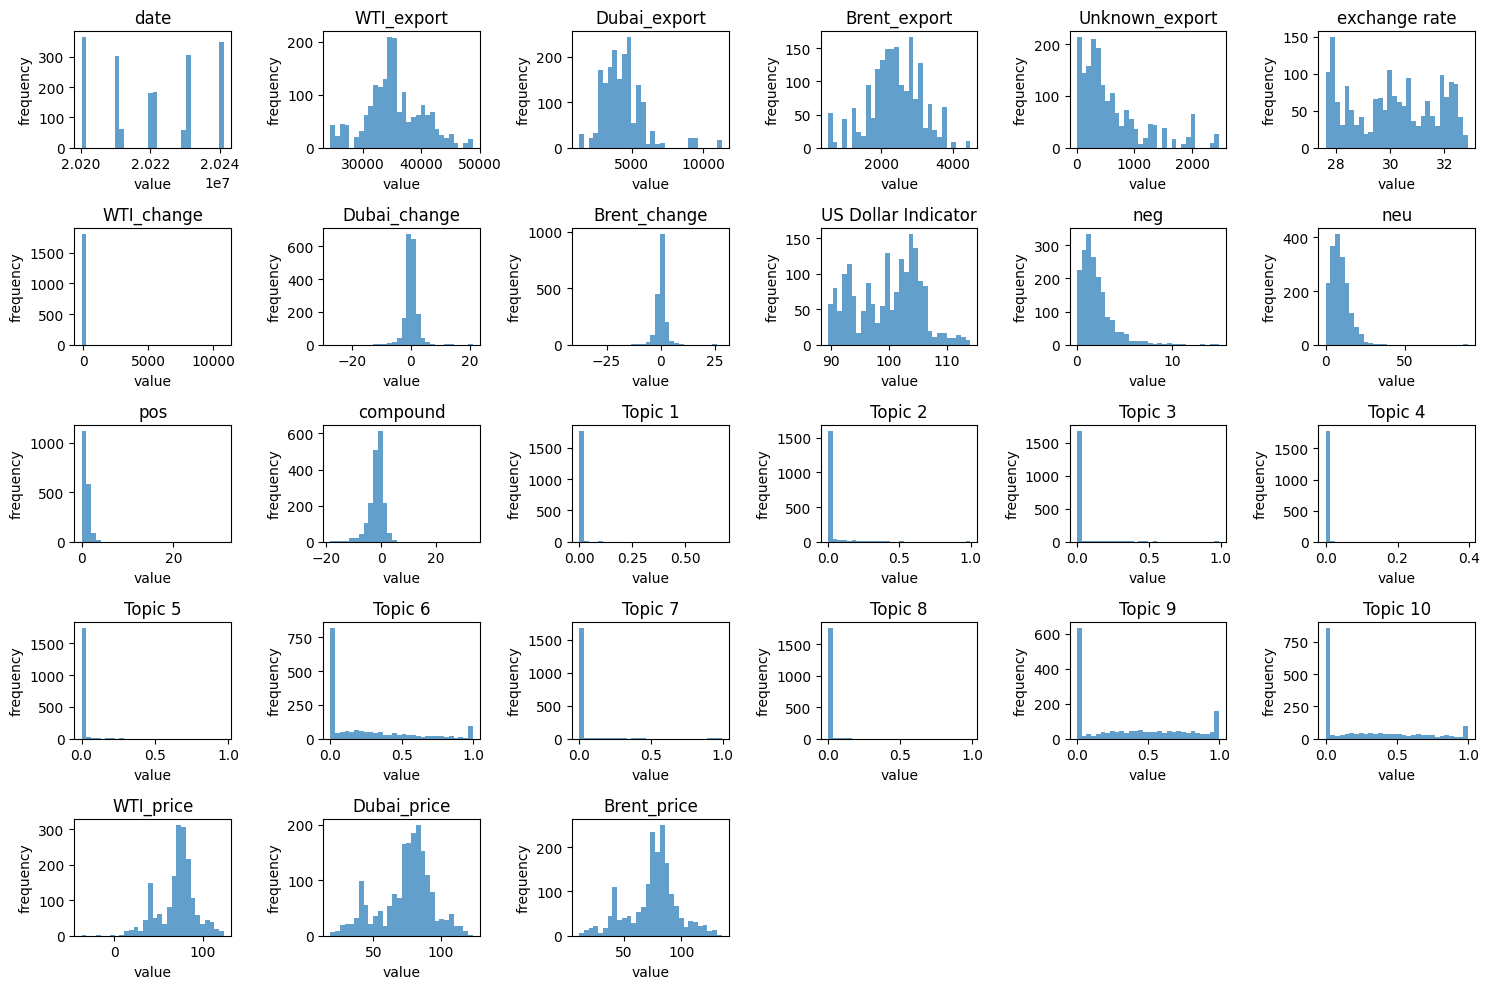

In [216]:
# 畫出所有特徵的 histogram，看數據的分布
plt.figure(figsize=(15, 10))
for i, column in enumerate(train_df.columns):
    plt.subplot(5, 6, i + 1)
    plt.hist(data_df[column], bins=30, alpha=0.7)
    plt.title(column)
    plt.xlabel('value')
    plt.ylabel('frequency')
plt.tight_layout()
plt.show()


In [257]:
def split_features(df, target_feature, train=True, scaler=None, selected_features=None, ):
    # 滯後特徵
    df['lag_7'] = df[target_feature].shift(7)
    # 預定義數值型和 NLP 特徵列表
    numeric_features_all = ['WTI_export', 'Dubai_export', 'Brent_export', 'Unknown_export', 
                            'exchange rate', 'WTI_change', 'Dubai_change', 'Brent_change', 
                            'US Dollar Indicator', 'lag_7', 'WTI_price', 'Dubai_price', 'Brent_price']
    nlp_features_all = ['neg', 'neu', 'pos', 'compound', 
                        'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 
                        'Topic 6', 'Topic 7', 'Topic 8', 'Topic 9', 'Topic 10']

    if train:
        # 計算特徵重要性 (僅基於訓練集)
        xgb_model = XGBRegressor(n_estimators=143, learning_rate=0.026209147132450806, max_depth=4, random_state=42)
        lgb_model = LGBMRegressor(n_estimators=186, learning_rate=0.01162835695998187, max_depth=3, random_state=42)
        cat_model = CatBoostRegressor(n_estimators=252, learning_rate=0.0868940443602814, depth=3, verbose=0, random_state=42)
        xgb_model.fit(df, df[target_feature])  
        lgb_model.fit(df, df[target_feature])  
        cat_model.fit(df, df[target_feature])  
        xgb_importances = xgb_model.feature_importances_
        lgb_importances = lgb_model.feature_importances_
        cat_importances = cat_model.feature_importances_
        feature_importances = np.mean([xgb_importances, lgb_importances, cat_importances], axis=0)
        feature_names = df.columns
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

        # 保存選擇的特徵
        selected_features = importance_df[importance_df['Importance'] > 0.01]['Feature'].tolist()

    # 確保valid和test使用相同的特徵
    # df = df[selected_features]
    X_numeric = df[numeric_features_all].loc[:, df[numeric_features_all].columns.isin(selected_features)]
    numeric_features = X_numeric.columns
    X_nlp = df[nlp_features_all].loc[:, df[nlp_features_all].columns.isin(selected_features)]
    if train:
        scaler = MinMaxScaler()
        X_numeric = scaler.fit_transform(X_numeric)
    else:
        X_numeric = scaler.transform(X_numeric)
    X = pd.concat([pd.DataFrame(X_numeric, columns=numeric_features), X_nlp.reset_index(drop=True)], axis=1)
    
    return scaler, X, selected_features

def split_dataset(df, target_feature):
    y = df[target_feature]
    x = df.drop(columns=[target_feature])
    return y, x


In [258]:
######### for WTI price #########
# print(train_df.columns)
scaler, X_WTI_train, selected_features = split_features(train_df, target_feature='WTI_price', train=True)
_, X_WTI_valid, _ = split_features(valid_df, target_feature='WTI_price', train=False, scaler=scaler, selected_features=selected_features)
_, X_WTI_test, _ = split_features(test_df, target_feature='WTI_price', train=False, scaler=scaler, selected_features=selected_features)

y_WTI_train, X_WTI_train = split_dataset(X_WTI_train, target_feature='WTI_price')
y_WTI_valid, X_WTI_valid = split_dataset(X_WTI_valid, target_feature='WTI_price')
y_WTI_test, X_WTI_test = split_dataset(X_WTI_test, target_feature='WTI_price')
X_WTI_train = X_WTI_train.drop(columns=['Dubai_price', 'Brent_price'])
X_WTI_valid = X_WTI_valid.drop(columns=['Dubai_price', 'Brent_price'])
X_WTI_test = X_WTI_test.drop(columns=['Dubai_price', 'Brent_price'])

X_WTI_train


,Brent_export,Unknown_export,exchange rate,WTI_change,US Dollar Indicator,lag_7,Topic 6,Topic 10
0,0.222795,0.348567,0.513347,0.011851,0.281719,NaN,0.000606,0.000606
1,0.222795,0.348567,0.513347,0.011302,0.300365,NaN,0.409723,0.580864
2,0.222795,0.348567,0.511294,0.011575,0.299959,NaN,0.000662,0.994039
3,0.292944,0.418282,0.513347,0.011315,0.297527,NaN,0.128271,0.394805
4,0.292944,0.418282,0.513347,0.011315,0.295501,NaN,0.000720,0.922364
...,...,...,...,...,...,...,...,...
1547,0.599011,0.106157,0.901437,0.011273,0.604378,0.755946,0.359257,0.078998
1548,0.599011,0.106157,0.899384,0.011503,0.612485,0.745984,0.001235,0.443412
1549,0.599011,0.106157,0.899384,0.011318,0.612485,0.741004,0.138075,0.001493
1550,0.744400,0.127387,0.897331,0.011319,0.618970,0.739136,0.000388,0.531746


In [259]:
######### for Dubai price #########
scaler, X_Dubai_train, selected_features = split_features(train_df, target_feature='Dubai_price', train=True)
_, X_Dubai_valid, _ = split_features(valid_df, target_feature='Dubai_price', train=False, scaler=scaler, selected_features=selected_features)
_, X_Dubai_test, _ = split_features(test_df, target_feature='Dubai_price', train=False, scaler=scaler, selected_features=selected_features)

y_Dubai_train, X_Dubai_train = split_dataset(X_Dubai_train, target_feature='Dubai_price')
y_Dubai_valid, X_Dubai_valid = split_dataset(X_Dubai_valid, target_feature='Dubai_price')
y_Dubai_test, X_Dubai_test = split_dataset(X_Dubai_test, target_feature='Dubai_price')
X_Dubai_train = X_Dubai_train.drop(columns=['WTI_price', 'Brent_price'])
X_Dubai_valid = X_Dubai_valid.drop(columns=['WTI_price', 'Brent_price'])
X_Dubai_test = X_Dubai_test.drop(columns=['WTI_price', 'Brent_price'])

X_Dubai_train

,Unknown_export,exchange rate,Dubai_change,US Dollar Indicator,lag_7
0,0.348567,0.513347,0.566097,0.281719,NaN
1,0.348567,0.513347,0.565423,0.300365,NaN
2,0.348567,0.511294,0.645374,0.299959,NaN
3,0.418282,0.513347,0.567484,0.297527,NaN
4,0.418282,0.513347,0.567484,0.295501,NaN
...,...,...,...,...,...
1547,0.106157,0.901437,0.540490,0.604378,0.672854
1548,0.106157,0.899384,0.581496,0.612485,0.666381
1549,0.106157,0.899384,0.572223,0.612485,0.658195
1550,0.127387,0.897331,0.572017,0.618970,0.657719


In [260]:
######### for Brent price #########
scaler, X_Brent_train, selected_features = split_features(train_df, target_feature='Brent_price', train=True)
_, X_Brent_valid, _ = split_features(valid_df, target_feature='Brent_price', train=False, scaler=scaler, selected_features=selected_features)
_, X_Brent_test, _ = split_features(test_df, target_feature='Brent_price', train=False, scaler=scaler, selected_features=selected_features)

y_Brent_train, X_Brent_train = split_dataset(X_Brent_train, target_feature='Brent_price')
y_Brent_valid, X_Brent_valid = split_dataset(X_Brent_valid, target_feature='Brent_price')
y_Brent_test, X_Brent_test = split_dataset(X_Brent_test, target_feature='Brent_price')
X_Brent_train = X_Brent_train.drop(columns=['WTI_price', 'Dubai_price'])
X_Brent_valid = X_Brent_valid.drop(columns=['WTI_price', 'Dubai_price'])
X_Brent_test = X_Brent_test.drop(columns=['WTI_price', 'Dubai_price'])

X_Brent_train

,Dubai_export,Unknown_export,exchange rate,US Dollar Indicator,lag_7
0,0.405681,0.348567,0.513347,0.281719,NaN
1,0.405681,0.348567,0.513347,0.300365,NaN
2,0.405681,0.348567,0.511294,0.299959,NaN
3,0.513605,0.418282,0.513347,0.297527,NaN
4,0.513605,0.418282,0.513347,0.295501,NaN
...,...,...,...,...,...
1547,0.247687,0.106157,0.901437,0.604378,0.603339
1548,0.247687,0.106157,0.899384,0.612485,0.596450
1549,0.247687,0.106157,0.899384,0.612485,0.596045
1550,0.324012,0.127387,0.897331,0.618970,0.599611


## Training Model

In [248]:
class Objective:
    def __init__(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def __call__(self, trial):
        # XGBoost 參數
        xgb_model = XGBRegressor(
            n_estimators=trial.suggest_int('xgb_n_estimators', 100, 150),
            learning_rate=trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.1),
            max_depth=trial.suggest_int('xgb_max_depth', 3, 6),
            subsample=trial.suggest_uniform('xgb_subsample', 0.7, 1.0),
            colsample_bytree=trial.suggest_uniform('xgb_colsample_bytree', 0.7, 1.0),
            alpha=trial.suggest_loguniform('xgb_alpha', 1e-3, 1),
            lambda_=trial.suggest_loguniform('xgb_lambda', 1e-3, 1),
            random_state=42
        )

        # LightGBM 參數
        lgb_model = LGBMRegressor(
            n_estimators=trial.suggest_int('lgb_n_estimators', 100, 150),
            learning_rate=trial.suggest_loguniform('lgb_learning_rate', 0.01, 0.1),
            max_depth=trial.suggest_int('lgb_max_depth', 3, 6),
            subsample=trial.suggest_uniform('lgb_subsample', 0.7, 1.0),
            colsample_bytree=trial.suggest_uniform('lgb_colsample_bytree', 0.7, 1.0),
            reg_alpha=trial.suggest_loguniform('lgb_reg_alpha', 1e-3, 1),
            reg_lambda=trial.suggest_loguniform('lgb_reg_lambda', 1e-3, 1),
            random_state=42
        )

        # CatBoost 參數
        cat_model = CatBoostRegressor(
            n_estimators=trial.suggest_int('cat_n_estimators', 100, 150),
            learning_rate=trial.suggest_loguniform('cat_learning_rate', 0.01, 0.1),
            depth=trial.suggest_int('cat_depth', 3, 6),
            verbose=0,
            random_state=42
        )

        # Stacking 模型
        stacking_model = StackingRegressor(
            estimators=[
                ('xgb', xgb_model),
                ('lgb', lgb_model),
                ('cat', cat_model),
            ],
            final_estimator=LinearRegression()
        )

        print(type(X_WTI_train))
        print(type(y_WTI_train))
        score = cross_val_score(stacking_model, self.X_train, self.y_train, cv=5, scoring='neg_mean_squared_error')
        return -score.mean()




In [249]:
################ 超參數調整 #################
# # trial (需要重新搜索時再uncomment)
# WTI_study = optuna.create_study(direction='minimize')
# WTI_study.optimize(Objective(X_WTI_train, y_WTI_train), n_trials=10)

# Dubai_study = optuna.create_study(direction='minimize')
# Dubai_study.optimize(Objective(X_Dubai_train, y_Dubai_train), n_trials=10)

# Brent_study = optuna.create_study(direction='minimize')
# Brent_study.optimize(Objective(X_Brent_train, y_Brent_train), n_trials=10)


# with open('WTI_best_hyperparameters.json', 'w') as f:
#     json.dump(WTI_study.best_params, f)
# with open('Dubai_best_hyperparameters.json', 'w') as f:
#     json.dump(Dubai_study.best_params, f)
# with open('Brent_best_hyperparameters.json', 'w') as f:
#     json.dump(Brent_study.best_params, f)

[I 2025-01-12 22:30:22,775] A new study created in memory with name: no-name-ccbf2053-4596-4c6f-a112-f8decbb883c7


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


[I 2025-01-12 22:30:37,096] Trial 0 finished with value: 0.003676887164489685 and parameters: {'xgb_n_estimators': 150, 'xgb_learning_rate': 0.04056543852395634, 'xgb_max_depth': 3, 'xgb_subsample': 0.887816771899861, 'xgb_colsample_bytree': 0.8456009563047625, 'xgb_alpha': 0.018792204852069887, 'xgb_lambda': 0.10574265686803094, 'lgb_n_estimators': 139, 'lgb_learning_rate': 0.039323847470161856, 'lgb_max_depth': 5, 'lgb_subsample': 0.9229666699926031, 'lgb_colsample_bytree': 0.8839739422785876, 'lgb_reg_alpha': 0.07985592739715619, 'lgb_reg_lambda': 0.0563826071468667, 'cat_n_estimators': 138, 'cat_learning_rate': 0.033256408708311196, 'cat_depth': 5}. Best is trial 0 with value: 0.003676887164489685.


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


[I 2025-01-12 22:30:53,903] Trial 1 finished with value: 0.00436469105231307 and parameters: {'xgb_n_estimators': 146, 'xgb_learning_rate': 0.016446273902853914, 'xgb_max_depth': 4, 'xgb_subsample': 0.8803247163157938, 'xgb_colsample_bytree': 0.808127061082834, 'xgb_alpha': 0.10075141860072169, 'xgb_lambda': 0.02413725977596617, 'lgb_n_estimators': 109, 'lgb_learning_rate': 0.024699329921262503, 'lgb_max_depth': 3, 'lgb_subsample': 0.9983246168703435, 'lgb_colsample_bytree': 0.9555941667769127, 'lgb_reg_alpha': 0.1554100209068193, 'lgb_reg_lambda': 0.06520126570209413, 'cat_n_estimators': 132, 'cat_learning_rate': 0.06555502398635384, 'cat_depth': 6}. Best is trial 0 with value: 0.003676887164489685.


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


[I 2025-01-12 22:31:11,543] Trial 2 finished with value: 0.005676285638412772 and parameters: {'xgb_n_estimators': 116, 'xgb_learning_rate': 0.012212140186875489, 'xgb_max_depth': 3, 'xgb_subsample': 0.9092081790832944, 'xgb_colsample_bytree': 0.7491512720470888, 'xgb_alpha': 0.002426765650449991, 'xgb_lambda': 0.4781452710313287, 'lgb_n_estimators': 132, 'lgb_learning_rate': 0.013540260629298067, 'lgb_max_depth': 6, 'lgb_subsample': 0.8385696337078241, 'lgb_colsample_bytree': 0.7341448613419912, 'lgb_reg_alpha': 0.09337479376588423, 'lgb_reg_lambda': 0.023509629375454727, 'cat_n_estimators': 141, 'cat_learning_rate': 0.030058709167245488, 'cat_depth': 6}. Best is trial 0 with value: 0.003676887164489685.


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


[I 2025-01-12 22:31:22,797] Trial 3 finished with value: 0.004982041100645757 and parameters: {'xgb_n_estimators': 134, 'xgb_learning_rate': 0.018252071122516877, 'xgb_max_depth': 4, 'xgb_subsample': 0.737462450537333, 'xgb_colsample_bytree': 0.8075028178815955, 'xgb_alpha': 0.3357209653437221, 'xgb_lambda': 0.23946869614446445, 'lgb_n_estimators': 148, 'lgb_learning_rate': 0.014547477283957888, 'lgb_max_depth': 3, 'lgb_subsample': 0.9031282848770661, 'lgb_colsample_bytree': 0.8537715354711373, 'lgb_reg_alpha': 0.01538765149782182, 'lgb_reg_lambda': 0.05789976571810689, 'cat_n_estimators': 138, 'cat_learning_rate': 0.05815969089389005, 'cat_depth': 4}. Best is trial 0 with value: 0.003676887164489685.


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


[I 2025-01-12 22:31:34,205] Trial 4 finished with value: 0.005348451986435141 and parameters: {'xgb_n_estimators': 132, 'xgb_learning_rate': 0.018718009933799604, 'xgb_max_depth': 6, 'xgb_subsample': 0.984815028398568, 'xgb_colsample_bytree': 0.7394076741786976, 'xgb_alpha': 0.042693708160728955, 'xgb_lambda': 0.16474953306840995, 'lgb_n_estimators': 122, 'lgb_learning_rate': 0.01568784743102971, 'lgb_max_depth': 4, 'lgb_subsample': 0.9467955153072333, 'lgb_colsample_bytree': 0.8054429110458005, 'lgb_reg_alpha': 0.06801405886386036, 'lgb_reg_lambda': 0.0820595627627343, 'cat_n_estimators': 119, 'cat_learning_rate': 0.013675813421268106, 'cat_depth': 3}. Best is trial 0 with value: 0.003676887164489685.


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


[I 2025-01-12 22:31:52,202] Trial 5 finished with value: 0.00306064968773724 and parameters: {'xgb_n_estimators': 115, 'xgb_learning_rate': 0.04536495217033997, 'xgb_max_depth': 4, 'xgb_subsample': 0.8034729497689403, 'xgb_colsample_bytree': 0.7499049982800268, 'xgb_alpha': 0.07890527541168409, 'xgb_lambda': 0.019658030921830605, 'lgb_n_estimators': 142, 'lgb_learning_rate': 0.01753901994751953, 'lgb_max_depth': 4, 'lgb_subsample': 0.8736704700239899, 'lgb_colsample_bytree': 0.8682781528969563, 'lgb_reg_alpha': 0.04658153242344288, 'lgb_reg_lambda': 0.017237589313830234, 'cat_n_estimators': 149, 'cat_learning_rate': 0.035159697979021624, 'cat_depth': 6}. Best is trial 5 with value: 0.00306064968773724.


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


[I 2025-01-12 22:32:02,472] Trial 6 finished with value: 0.002949903592497755 and parameters: {'xgb_n_estimators': 108, 'xgb_learning_rate': 0.025533664513122098, 'xgb_max_depth': 5, 'xgb_subsample': 0.8923468989336554, 'xgb_colsample_bytree': 0.878741312748386, 'xgb_alpha': 0.00150454837695341, 'xgb_lambda': 0.016920193128412607, 'lgb_n_estimators': 115, 'lgb_learning_rate': 0.02193509815692593, 'lgb_max_depth': 3, 'lgb_subsample': 0.8617369924778103, 'lgb_colsample_bytree': 0.7649652234328457, 'lgb_reg_alpha': 0.013311619224191754, 'lgb_reg_lambda': 0.008117542187771313, 'cat_n_estimators': 128, 'cat_learning_rate': 0.030191611814383238, 'cat_depth': 3}. Best is trial 6 with value: 0.002949903592497755.


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


[I 2025-01-12 22:32:13,266] Trial 7 finished with value: 0.0042858937936274665 and parameters: {'xgb_n_estimators': 120, 'xgb_learning_rate': 0.05142064169764681, 'xgb_max_depth': 5, 'xgb_subsample': 0.870620193552951, 'xgb_colsample_bytree': 0.7099340494791622, 'xgb_alpha': 0.9992054723087497, 'xgb_lambda': 0.85245988929888, 'lgb_n_estimators': 138, 'lgb_learning_rate': 0.0293011461913443, 'lgb_max_depth': 5, 'lgb_subsample': 0.8354938349802924, 'lgb_colsample_bytree': 0.8227678440857679, 'lgb_reg_alpha': 0.1333377418760793, 'lgb_reg_lambda': 0.9898741122977428, 'cat_n_estimators': 138, 'cat_learning_rate': 0.09169514351890895, 'cat_depth': 3}. Best is trial 6 with value: 0.002949903592497755.


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


[I 2025-01-12 22:32:24,881] Trial 8 finished with value: 0.003916151435449442 and parameters: {'xgb_n_estimators': 145, 'xgb_learning_rate': 0.05951822310608421, 'xgb_max_depth': 3, 'xgb_subsample': 0.8436856814550914, 'xgb_colsample_bytree': 0.9303182453803418, 'xgb_alpha': 0.7238691399745429, 'xgb_lambda': 0.23390479672836306, 'lgb_n_estimators': 134, 'lgb_learning_rate': 0.06655823506498924, 'lgb_max_depth': 5, 'lgb_subsample': 0.8294699305505164, 'lgb_colsample_bytree': 0.968389361135063, 'lgb_reg_alpha': 0.39291920320146745, 'lgb_reg_lambda': 0.01707277533537122, 'cat_n_estimators': 100, 'cat_learning_rate': 0.028814552492537303, 'cat_depth': 5}. Best is trial 6 with value: 0.002949903592497755.


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


[I 2025-01-12 22:32:36,089] Trial 9 finished with value: 0.0029275522142621895 and parameters: {'xgb_n_estimators': 148, 'xgb_learning_rate': 0.04345724434430484, 'xgb_max_depth': 4, 'xgb_subsample': 0.9246026996349356, 'xgb_colsample_bytree': 0.876047180064534, 'xgb_alpha': 0.13468698957128106, 'xgb_lambda': 0.26156527334693597, 'lgb_n_estimators': 114, 'lgb_learning_rate': 0.03825478998717408, 'lgb_max_depth': 4, 'lgb_subsample': 0.8732847936492811, 'lgb_colsample_bytree': 0.9672065478738813, 'lgb_reg_alpha': 0.0017261542491108942, 'lgb_reg_lambda': 0.6334985953055233, 'cat_n_estimators': 123, 'cat_learning_rate': 0.015031050838237376, 'cat_depth': 4}. Best is trial 9 with value: 0.0029275522142621895.
[I 2025-01-12 22:32:36,092] A new study created in memory with name: no-name-8a720e92-e9ad-48be-933a-fdab39bb24de


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


[I 2025-01-12 22:32:48,759] Trial 0 finished with value: 0.007959990867916138 and parameters: {'xgb_n_estimators': 150, 'xgb_learning_rate': 0.010475973297743631, 'xgb_max_depth': 5, 'xgb_subsample': 0.8803208860418852, 'xgb_colsample_bytree': 0.7124919130484784, 'xgb_alpha': 0.4435227318107964, 'xgb_lambda': 0.016437485294665564, 'lgb_n_estimators': 148, 'lgb_learning_rate': 0.022505010477717153, 'lgb_max_depth': 6, 'lgb_subsample': 0.9697471952508806, 'lgb_colsample_bytree': 0.7670239517746431, 'lgb_reg_alpha': 0.007121813643238061, 'lgb_reg_lambda': 0.019465582278678943, 'cat_n_estimators': 134, 'cat_learning_rate': 0.01353032553312954, 'cat_depth': 4}. Best is trial 0 with value: 0.007959990867916138.


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


[I 2025-01-12 22:33:05,440] Trial 1 finished with value: 0.004826108762384211 and parameters: {'xgb_n_estimators': 141, 'xgb_learning_rate': 0.02243696597838369, 'xgb_max_depth': 6, 'xgb_subsample': 0.7329600596911882, 'xgb_colsample_bytree': 0.8951929702360247, 'xgb_alpha': 0.1901011096974592, 'xgb_lambda': 0.05398686195204471, 'lgb_n_estimators': 108, 'lgb_learning_rate': 0.022319509326864183, 'lgb_max_depth': 5, 'lgb_subsample': 0.7785339605916318, 'lgb_colsample_bytree': 0.9181058030481488, 'lgb_reg_alpha': 0.02517398700803483, 'lgb_reg_lambda': 0.016989230785867313, 'cat_n_estimators': 119, 'cat_learning_rate': 0.051597358039802095, 'cat_depth': 6}. Best is trial 1 with value: 0.004826108762384211.


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


[I 2025-01-12 22:33:15,535] Trial 2 finished with value: 0.006866850706026781 and parameters: {'xgb_n_estimators': 113, 'xgb_learning_rate': 0.029990942853450102, 'xgb_max_depth': 6, 'xgb_subsample': 0.7060843530444018, 'xgb_colsample_bytree': 0.9593633490298797, 'xgb_alpha': 0.00274266056095665, 'xgb_lambda': 0.14758325291110658, 'lgb_n_estimators': 103, 'lgb_learning_rate': 0.07951341069077798, 'lgb_max_depth': 6, 'lgb_subsample': 0.9129762701002013, 'lgb_colsample_bytree': 0.7770432457104552, 'lgb_reg_alpha': 0.8531314942791582, 'lgb_reg_lambda': 0.08782805529029052, 'cat_n_estimators': 119, 'cat_learning_rate': 0.03494052692057, 'cat_depth': 3}. Best is trial 1 with value: 0.004826108762384211.


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


[I 2025-01-12 22:33:26,671] Trial 3 finished with value: 0.006301419831466089 and parameters: {'xgb_n_estimators': 123, 'xgb_learning_rate': 0.03871619885193483, 'xgb_max_depth': 5, 'xgb_subsample': 0.7358538976714083, 'xgb_colsample_bytree': 0.9286810329499742, 'xgb_alpha': 0.003384307134179263, 'xgb_lambda': 0.024171199985213245, 'lgb_n_estimators': 146, 'lgb_learning_rate': 0.037307085883424886, 'lgb_max_depth': 6, 'lgb_subsample': 0.8684698088508871, 'lgb_colsample_bytree': 0.9042862528695339, 'lgb_reg_alpha': 0.9374837303808122, 'lgb_reg_lambda': 0.039236255934787384, 'cat_n_estimators': 124, 'cat_learning_rate': 0.011581889049619676, 'cat_depth': 4}. Best is trial 1 with value: 0.004826108762384211.


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


[I 2025-01-12 22:33:36,779] Trial 4 finished with value: 0.012865298945586311 and parameters: {'xgb_n_estimators': 104, 'xgb_learning_rate': 0.02078140542442759, 'xgb_max_depth': 3, 'xgb_subsample': 0.863814958610571, 'xgb_colsample_bytree': 0.9898183626613042, 'xgb_alpha': 0.9574649165132942, 'xgb_lambda': 0.0011479779997882454, 'lgb_n_estimators': 109, 'lgb_learning_rate': 0.026271352625276956, 'lgb_max_depth': 3, 'lgb_subsample': 0.8455378205848708, 'lgb_colsample_bytree': 0.7160709675162321, 'lgb_reg_alpha': 0.7209256037542655, 'lgb_reg_lambda': 0.019521157641979814, 'cat_n_estimators': 105, 'cat_learning_rate': 0.04373026779867244, 'cat_depth': 5}. Best is trial 1 with value: 0.004826108762384211.


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


[I 2025-01-12 22:33:49,246] Trial 5 finished with value: 0.012787174809896048 and parameters: {'xgb_n_estimators': 111, 'xgb_learning_rate': 0.022363860405842203, 'xgb_max_depth': 3, 'xgb_subsample': 0.7733957995626959, 'xgb_colsample_bytree': 0.7007003636055934, 'xgb_alpha': 0.0025928214067750636, 'xgb_lambda': 0.18769579133334788, 'lgb_n_estimators': 116, 'lgb_learning_rate': 0.035820424141530124, 'lgb_max_depth': 6, 'lgb_subsample': 0.8330449485192941, 'lgb_colsample_bytree': 0.8044011118533729, 'lgb_reg_alpha': 0.3089034214652596, 'lgb_reg_lambda': 0.004258387019319917, 'cat_n_estimators': 129, 'cat_learning_rate': 0.022438840131458904, 'cat_depth': 5}. Best is trial 1 with value: 0.004826108762384211.


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


[I 2025-01-12 22:34:04,201] Trial 6 finished with value: 0.005884572088925053 and parameters: {'xgb_n_estimators': 118, 'xgb_learning_rate': 0.06311796747575513, 'xgb_max_depth': 3, 'xgb_subsample': 0.737873617414753, 'xgb_colsample_bytree': 0.8293942746473217, 'xgb_alpha': 0.6028822716231754, 'xgb_lambda': 0.002591667745580351, 'lgb_n_estimators': 138, 'lgb_learning_rate': 0.028409106963284816, 'lgb_max_depth': 6, 'lgb_subsample': 0.8721055971032029, 'lgb_colsample_bytree': 0.8444841587864704, 'lgb_reg_alpha': 0.0012276552173303822, 'lgb_reg_lambda': 0.0030046644733837165, 'cat_n_estimators': 107, 'cat_learning_rate': 0.046099552415004526, 'cat_depth': 6}. Best is trial 1 with value: 0.004826108762384211.


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


[I 2025-01-12 22:34:13,568] Trial 7 finished with value: 0.011447912173624987 and parameters: {'xgb_n_estimators': 116, 'xgb_learning_rate': 0.04328425356901585, 'xgb_max_depth': 4, 'xgb_subsample': 0.8958576246971757, 'xgb_colsample_bytree': 0.7224746527397848, 'xgb_alpha': 0.12382671081370228, 'xgb_lambda': 0.0025452613268047673, 'lgb_n_estimators': 137, 'lgb_learning_rate': 0.0605054847157566, 'lgb_max_depth': 4, 'lgb_subsample': 0.8169173959272025, 'lgb_colsample_bytree': 0.8595618904996761, 'lgb_reg_alpha': 0.24174116564417014, 'lgb_reg_lambda': 0.20426194594877736, 'cat_n_estimators': 125, 'cat_learning_rate': 0.010341357029615672, 'cat_depth': 3}. Best is trial 1 with value: 0.004826108762384211.


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


[I 2025-01-12 22:34:27,299] Trial 8 finished with value: 0.007961167246234436 and parameters: {'xgb_n_estimators': 110, 'xgb_learning_rate': 0.016767687174522424, 'xgb_max_depth': 4, 'xgb_subsample': 0.8971944048417251, 'xgb_colsample_bytree': 0.9844290816791241, 'xgb_alpha': 0.7588165073154552, 'xgb_lambda': 0.0011824765869473965, 'lgb_n_estimators': 128, 'lgb_learning_rate': 0.05116883419982835, 'lgb_max_depth': 5, 'lgb_subsample': 0.819804584654599, 'lgb_colsample_bytree': 0.8476029225241067, 'lgb_reg_alpha': 0.041157893471539184, 'lgb_reg_lambda': 0.028782405052987237, 'cat_n_estimators': 102, 'cat_learning_rate': 0.024759618741390328, 'cat_depth': 6}. Best is trial 1 with value: 0.004826108762384211.


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


[I 2025-01-12 22:34:42,558] Trial 9 finished with value: 0.007893897649463754 and parameters: {'xgb_n_estimators': 131, 'xgb_learning_rate': 0.022936768160574064, 'xgb_max_depth': 6, 'xgb_subsample': 0.7643526408875139, 'xgb_colsample_bytree': 0.797489546069179, 'xgb_alpha': 0.037922369742824535, 'xgb_lambda': 0.005892389531169113, 'lgb_n_estimators': 108, 'lgb_learning_rate': 0.012083209460775245, 'lgb_max_depth': 5, 'lgb_subsample': 0.9964967072334265, 'lgb_colsample_bytree': 0.9455481941704741, 'lgb_reg_alpha': 0.047652851454276696, 'lgb_reg_lambda': 0.051779394510327634, 'cat_n_estimators': 101, 'cat_learning_rate': 0.016215974216872087, 'cat_depth': 6}. Best is trial 1 with value: 0.004826108762384211.
[I 2025-01-12 22:34:42,560] A new study created in memory with name: no-name-f501006b-f3a0-488d-b75e-256b5f41f74f


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


[I 2025-01-12 22:34:56,868] Trial 0 finished with value: 0.0049370169634895536 and parameters: {'xgb_n_estimators': 107, 'xgb_learning_rate': 0.01399962278766805, 'xgb_max_depth': 6, 'xgb_subsample': 0.9589662226168527, 'xgb_colsample_bytree': 0.9610291179247803, 'xgb_alpha': 0.08694586635977751, 'xgb_lambda': 0.22926158428702018, 'lgb_n_estimators': 101, 'lgb_learning_rate': 0.014315744374534058, 'lgb_max_depth': 4, 'lgb_subsample': 0.9592953652287212, 'lgb_colsample_bytree': 0.9808161278958674, 'lgb_reg_alpha': 0.06529660691185787, 'lgb_reg_lambda': 0.1950856575434939, 'cat_n_estimators': 106, 'cat_learning_rate': 0.012089290348286786, 'cat_depth': 6}. Best is trial 0 with value: 0.0049370169634895536.


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


[I 2025-01-12 22:35:12,976] Trial 1 finished with value: 0.006217625013501656 and parameters: {'xgb_n_estimators': 119, 'xgb_learning_rate': 0.012051847299722947, 'xgb_max_depth': 6, 'xgb_subsample': 0.7739772764211028, 'xgb_colsample_bytree': 0.7631791627119089, 'xgb_alpha': 0.004184877956631359, 'xgb_lambda': 0.024055426399074094, 'lgb_n_estimators': 126, 'lgb_learning_rate': 0.016369807976012517, 'lgb_max_depth': 5, 'lgb_subsample': 0.7991828423959381, 'lgb_colsample_bytree': 0.7978620818738086, 'lgb_reg_alpha': 0.11436683011283921, 'lgb_reg_lambda': 0.41744407068081724, 'cat_n_estimators': 113, 'cat_learning_rate': 0.08658792422713561, 'cat_depth': 6}. Best is trial 0 with value: 0.0049370169634895536.


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


[I 2025-01-12 22:35:27,218] Trial 2 finished with value: 0.008554281822801303 and parameters: {'xgb_n_estimators': 148, 'xgb_learning_rate': 0.05031604060336201, 'xgb_max_depth': 4, 'xgb_subsample': 0.8381489898802925, 'xgb_colsample_bytree': 0.8064139179845218, 'xgb_alpha': 0.019954812771574144, 'xgb_lambda': 0.054425555511250744, 'lgb_n_estimators': 124, 'lgb_learning_rate': 0.09825545763443698, 'lgb_max_depth': 3, 'lgb_subsample': 0.9253419798437669, 'lgb_colsample_bytree': 0.9163328755613296, 'lgb_reg_alpha': 0.9034050057133631, 'lgb_reg_lambda': 0.012634723163899124, 'cat_n_estimators': 107, 'cat_learning_rate': 0.0351349660449616, 'cat_depth': 6}. Best is trial 0 with value: 0.0049370169634895536.


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


[I 2025-01-12 22:35:40,286] Trial 3 finished with value: 0.006311636132822217 and parameters: {'xgb_n_estimators': 113, 'xgb_learning_rate': 0.04117989379673293, 'xgb_max_depth': 5, 'xgb_subsample': 0.8521338343659464, 'xgb_colsample_bytree': 0.7294811877043166, 'xgb_alpha': 0.03925948399825295, 'xgb_lambda': 0.005313020304909945, 'lgb_n_estimators': 124, 'lgb_learning_rate': 0.02586285969421957, 'lgb_max_depth': 6, 'lgb_subsample': 0.9885733458076063, 'lgb_colsample_bytree': 0.7376947787816245, 'lgb_reg_alpha': 0.0010766806930359797, 'lgb_reg_lambda': 0.01350132097667584, 'cat_n_estimators': 117, 'cat_learning_rate': 0.06791030201167234, 'cat_depth': 5}. Best is trial 0 with value: 0.0049370169634895536.


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


[I 2025-01-12 22:35:49,531] Trial 4 finished with value: 0.006863878491022964 and parameters: {'xgb_n_estimators': 109, 'xgb_learning_rate': 0.06255589960498449, 'xgb_max_depth': 3, 'xgb_subsample': 0.9929861383384994, 'xgb_colsample_bytree': 0.9759606270939856, 'xgb_alpha': 0.02912329469785846, 'xgb_lambda': 0.0015226243837241026, 'lgb_n_estimators': 124, 'lgb_learning_rate': 0.05753061125772428, 'lgb_max_depth': 4, 'lgb_subsample': 0.9103910676136265, 'lgb_colsample_bytree': 0.98255606951188, 'lgb_reg_alpha': 0.0025927354263140688, 'lgb_reg_lambda': 0.04547269638135061, 'cat_n_estimators': 139, 'cat_learning_rate': 0.0424779821575608, 'cat_depth': 3}. Best is trial 0 with value: 0.0049370169634895536.


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


[I 2025-01-12 22:36:06,028] Trial 5 finished with value: 0.004328824293204412 and parameters: {'xgb_n_estimators': 134, 'xgb_learning_rate': 0.014603131515217464, 'xgb_max_depth': 5, 'xgb_subsample': 0.93755328955588, 'xgb_colsample_bytree': 0.7864317230042231, 'xgb_alpha': 0.002648884125180074, 'xgb_lambda': 0.100136236999118, 'lgb_n_estimators': 120, 'lgb_learning_rate': 0.03943295015728283, 'lgb_max_depth': 5, 'lgb_subsample': 0.864909588323362, 'lgb_colsample_bytree': 0.9765382707139538, 'lgb_reg_alpha': 0.023921772933889984, 'lgb_reg_lambda': 0.003952413230500474, 'cat_n_estimators': 130, 'cat_learning_rate': 0.08183134171916119, 'cat_depth': 6}. Best is trial 5 with value: 0.004328824293204412.


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


[I 2025-01-12 22:36:15,382] Trial 6 finished with value: 0.004609200589683071 and parameters: {'xgb_n_estimators': 141, 'xgb_learning_rate': 0.01384359953095281, 'xgb_max_depth': 6, 'xgb_subsample': 0.8172918903195028, 'xgb_colsample_bytree': 0.8110301870303707, 'xgb_alpha': 0.004490464596691404, 'xgb_lambda': 0.0022386190398681746, 'lgb_n_estimators': 106, 'lgb_learning_rate': 0.016902885354297664, 'lgb_max_depth': 4, 'lgb_subsample': 0.7137053532497933, 'lgb_colsample_bytree': 0.9461243724002457, 'lgb_reg_alpha': 0.03457767794821074, 'lgb_reg_lambda': 0.33960806915555103, 'cat_n_estimators': 100, 'cat_learning_rate': 0.010817571171979236, 'cat_depth': 3}. Best is trial 5 with value: 0.004328824293204412.


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


[I 2025-01-12 22:36:24,676] Trial 7 finished with value: 0.012763791396723645 and parameters: {'xgb_n_estimators': 108, 'xgb_learning_rate': 0.05068768633445588, 'xgb_max_depth': 5, 'xgb_subsample': 0.8859169480871012, 'xgb_colsample_bytree': 0.9130545023391726, 'xgb_alpha': 0.1570484762577403, 'xgb_lambda': 0.2550099181775999, 'lgb_n_estimators': 132, 'lgb_learning_rate': 0.09735853463253885, 'lgb_max_depth': 5, 'lgb_subsample': 0.8279625066534321, 'lgb_colsample_bytree': 0.7270802766565976, 'lgb_reg_alpha': 0.24201696608768056, 'lgb_reg_lambda': 0.003569521783003266, 'cat_n_estimators': 128, 'cat_learning_rate': 0.012757787658374094, 'cat_depth': 3}. Best is trial 5 with value: 0.004328824293204412.


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


[I 2025-01-12 22:36:37,459] Trial 8 finished with value: 0.007324983442923991 and parameters: {'xgb_n_estimators': 126, 'xgb_learning_rate': 0.02208618365597721, 'xgb_max_depth': 4, 'xgb_subsample': 0.7877367751166933, 'xgb_colsample_bytree': 0.9435732441015915, 'xgb_alpha': 0.003034334666239724, 'xgb_lambda': 0.013567530090412552, 'lgb_n_estimators': 115, 'lgb_learning_rate': 0.011694622404000137, 'lgb_max_depth': 3, 'lgb_subsample': 0.7042311542710938, 'lgb_colsample_bytree': 0.7498016458920812, 'lgb_reg_alpha': 0.009664442383813065, 'lgb_reg_lambda': 0.09071614022692036, 'cat_n_estimators': 140, 'cat_learning_rate': 0.014153706686120647, 'cat_depth': 5}. Best is trial 5 with value: 0.004328824293204412.


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


[I 2025-01-12 22:36:48,034] Trial 9 finished with value: 0.008867463790924505 and parameters: {'xgb_n_estimators': 103, 'xgb_learning_rate': 0.04342922207186419, 'xgb_max_depth': 5, 'xgb_subsample': 0.7331546583929411, 'xgb_colsample_bytree': 0.7158105465723492, 'xgb_alpha': 0.005360502391642956, 'xgb_lambda': 0.002220352061405646, 'lgb_n_estimators': 148, 'lgb_learning_rate': 0.07138142168835497, 'lgb_max_depth': 3, 'lgb_subsample': 0.8838176537973599, 'lgb_colsample_bytree': 0.7876701794514689, 'lgb_reg_alpha': 0.05088195366373549, 'lgb_reg_lambda': 0.2520219771185109, 'cat_n_estimators': 101, 'cat_learning_rate': 0.041853578167316816, 'cat_depth': 5}. Best is trial 5 with value: 0.004328824293204412.


In [250]:
import json
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

############# Stacking #############
def create_stacking_model(filename, X_train, y_train):
    with open(filename, 'r') as f:
        best_params = json.load(f)

    # XGBoost 模型
    xgb_model = XGBRegressor(
        n_estimators=best_params['xgb_n_estimators'], 
        learning_rate=best_params['xgb_learning_rate'], 
        max_depth=best_params['xgb_max_depth'], 
        subsample=best_params['xgb_subsample'],  # 添加 subsample
        colsample_bytree=best_params['xgb_colsample_bytree'],  # 添加 colsample_bytree
        alpha=best_params['xgb_alpha'],  # 添加 L1 正則化
        lambda_=best_params['xgb_lambda'],  # 添加 L2 正則化
        random_state=42
    )

    # LightGBM 模型
    lgb_model = LGBMRegressor(
        n_estimators=best_params['lgb_n_estimators'], 
        learning_rate=best_params['lgb_learning_rate'], 
        max_depth=best_params['lgb_max_depth'],
        subsample=best_params['lgb_subsample'],  # 添加 subsample
        colsample_bytree=best_params['lgb_colsample_bytree'],  # 添加 colsample_bytree
        reg_alpha=best_params['lgb_reg_alpha'],  # 添加 L1 正則化
        reg_lambda=best_params['lgb_reg_lambda'],  # 添加 L2 正則化
        verbose=-1, 
        random_state=42
    )

    # CatBoost 模型
    cat_model = CatBoostRegressor(
        n_estimators=best_params['cat_n_estimators'], 
        learning_rate=best_params['cat_learning_rate'], 
        depth=best_params['cat_depth'], 
        verbose=0, 
        random_state=42
    )

    # 堆疊模型
    stacking_model = StackingRegressor(
        estimators=[
            ('xgb', xgb_model),
            ('lgb', lgb_model),
            ('cat', cat_model),
        ],
        final_estimator=LinearRegression()
    )

    # 訓練模型
    stacking_model.fit(X_train, y_train)
    return stacking_model

## Evaluation

In [261]:
def evaluate_model(X_train, y_train, X_valid, y_valid, X_test, y_test, hyperparameter_file):
    
    stacking_model = create_stacking_model(hyperparameter_file, X_train, y_train)
    
    # valid
    y_valid_pred = stacking_model.predict(X_valid)
    valid_mse = mean_squared_error(y_valid, y_valid_pred)
    valid_rmse = np.sqrt(valid_mse)
    valid_mae = mean_absolute_error(y_valid, y_valid_pred)
    valid_r2 = r2_score(y_valid, y_valid_pred)

    print("Validation MSE:", valid_mse)
    print("Validation RMSE:", valid_rmse)
    print("Validation MAE:", valid_mae)
    print("Validation R^2 Score:", valid_r2)

    # test
    y_test_pred = stacking_model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print("Test MSE:", test_mse)
    print("Test RMSE:", test_rmse)
    print("Test MAE:", test_mae)
    print("Test R^2 Score:", test_r2)

    return {
        'valid_mse': valid_mse,
        'valid_rmse': valid_rmse,
        'valid_mae': valid_mae,
        'valid_r2': valid_r2,
        'test_mse': test_mse,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'test_r2': test_r2
    }, y_valid_pred, y_test_pred

print("========= WTI =========")
metrics_wti, y_WTI_valid_pred, y_WTI_test_pred = evaluate_model(X_WTI_train, y_WTI_train, X_WTI_valid, y_WTI_valid, X_WTI_test, y_WTI_test, 'WTI_best_hyperparameters.json')
print("========= Dubai =========")
metrics_dubai, y_Dubai_valid_pred, y_Dubai_test_pred = evaluate_model(X_Dubai_train, y_Dubai_train, X_Dubai_valid, y_Dubai_valid, X_Dubai_test, y_Dubai_test, 'Dubai_best_hyperparameters.json')
print("========= Brent =========")
metrics_brent, y_Brent_valid_pred, y_Brent_test_pred = evaluate_model(X_Brent_train, y_Brent_train, X_Brent_valid, y_Brent_valid, X_Brent_test, y_Brent_test, 'Brent_best_hyperparameters.json')

========= WTI =========
Validation MSE: 0.00036825516408665746
Validation RMSE: 0.019189975614540458
Validation MAE: 0.013195126121042643
Validation R^2 Score: 0.05187775794522087
Test MSE: 0.0005059399282788014
Test RMSE: 0.02249310846190009
Test MAE: 0.017759546872739833
Test R^2 Score: 0.4871504859696235
========= Dubai =========
Validation MSE: 0.0008013325249298656
Validation RMSE: 0.02830781738195062
Validation MAE: 0.020551637590646113
Validation R^2 Score: 0.34426799866957103
Test MSE: 0.0016240951285223077
Test RMSE: 0.040300063629258795
Test MAE: 0.0333069749375319
Test R^2 Score: 0.19758673395709825
========= Brent =========
Validation MSE: 0.0008509386729614752
Validation RMSE: 0.029170853140788926
Validation MAE: 0.02337619666172058
Validation R^2 Score: 0.377255997139056
Test MSE: 0.0011862781782716264
Test RMSE: 0.0344423892648525
Test MAE: 0.027311109890114448
Test R^2 Score: 0.19852233207417236


In [266]:
def draw_accuracy_plot(date, actual_values, predicted_values, oil_type, dataset_type):
    plt.figure(figsize=(12, 6))
    
    date['date'] = pd.to_datetime(date['date'], format='%Y%m%d')
    
    plt.plot(date['date'], actual_values, label='Actual {dataset_type} Values', color='blue', marker='o')
    plt.plot(date['date'], predicted_values, label='Predicted {dataset_type} Values', color='orange', marker='x')
    plt.title(f'{oil_type} Actual vs Predicted {dataset_type} Values')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.grid()
    plt.show()


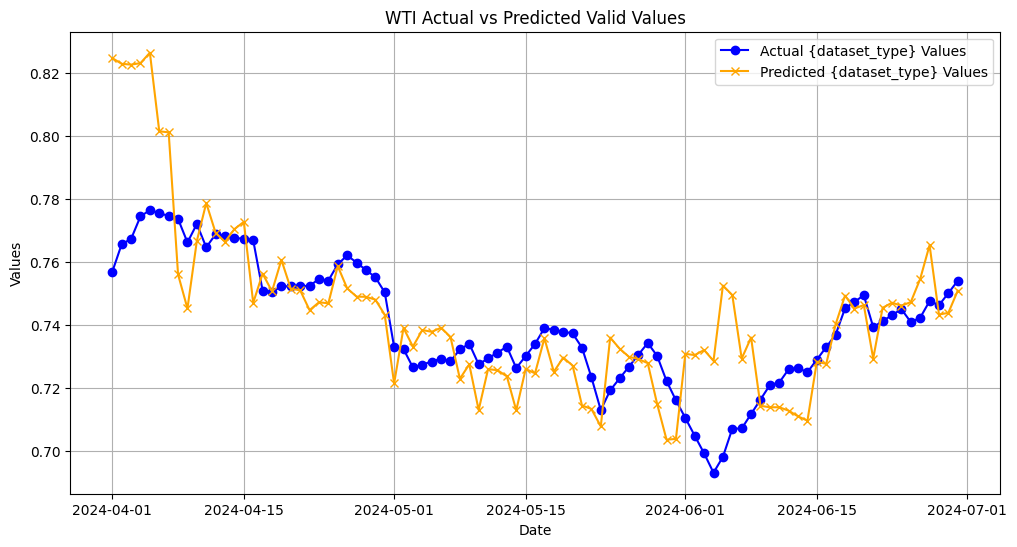

In [267]:
date = valid_df[['date']].reset_index(drop=True)
draw_accuracy_plot(date, y_WTI_valid, pd.Series(y_WTI_valid_pred, name="Predicted"), 'WTI', 'Valid')

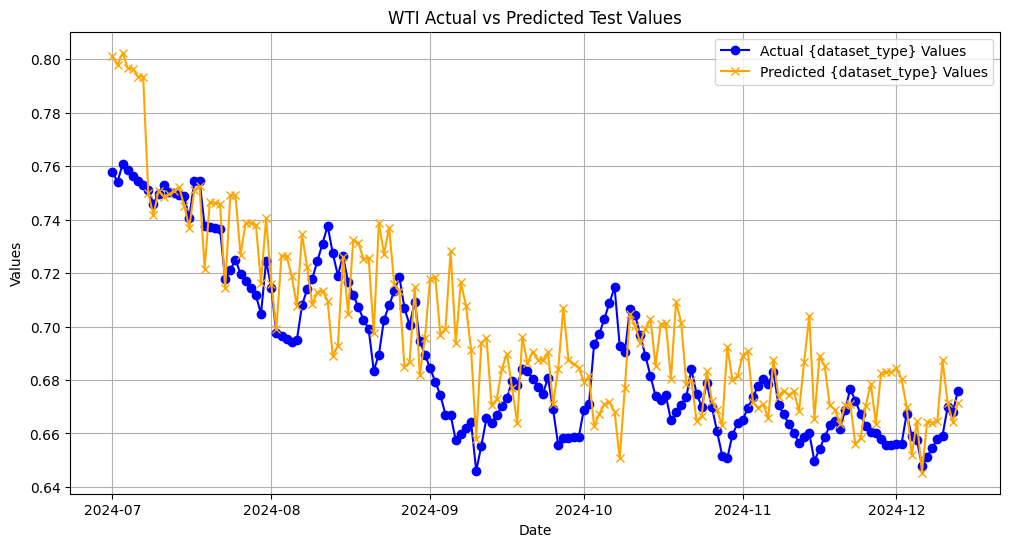

In [268]:
date = test_df[['date']].reset_index(drop=True)
draw_accuracy_plot(date, y_WTI_test, pd.Series(y_WTI_test_pred, name="Predicted"), 'WTI', 'Test')

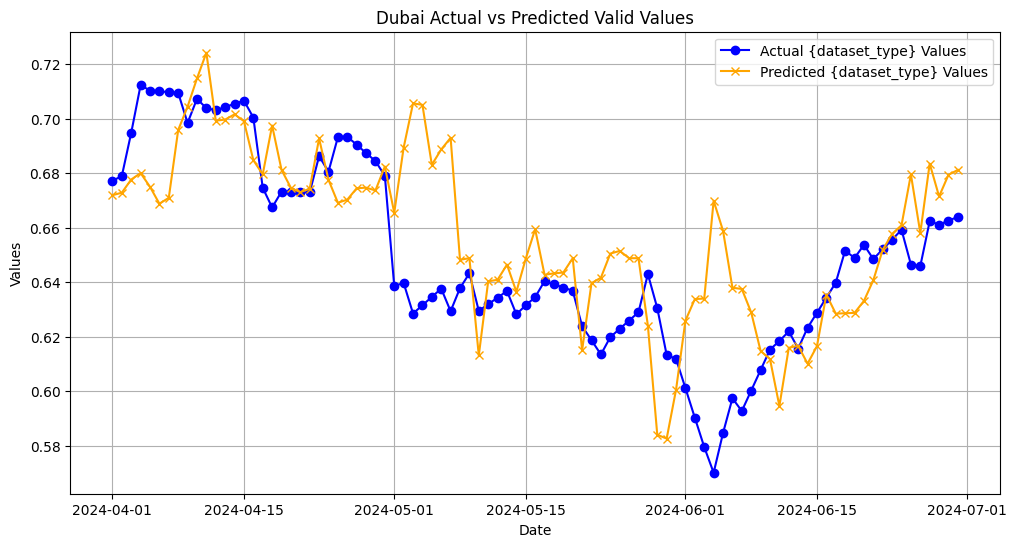

In [269]:
date = valid_df[['date']].reset_index(drop=True)
draw_accuracy_plot(date, y_Dubai_valid, pd.Series(y_Dubai_valid_pred, name="Predicted"), 'Dubai', 'Valid')

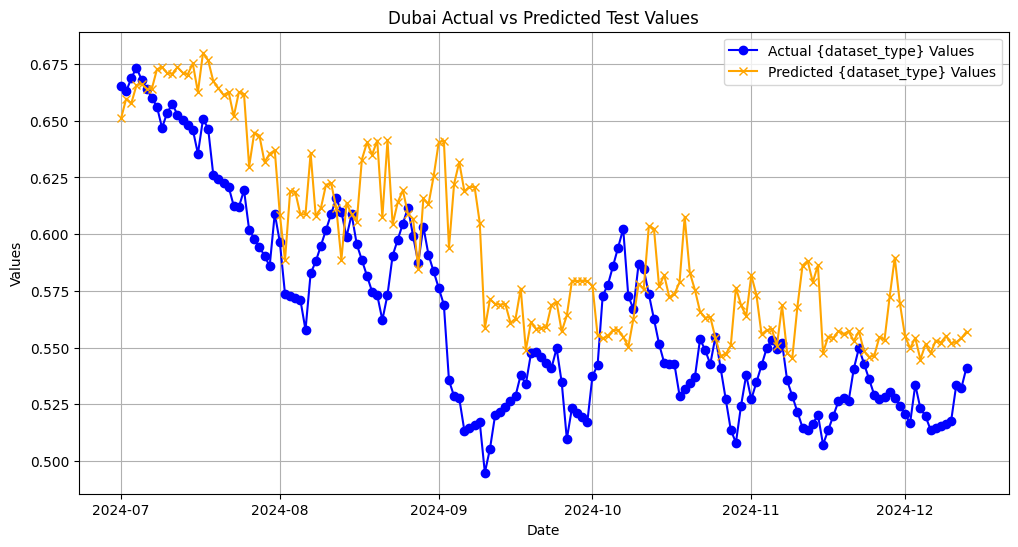

In [270]:
date = test_df[['date']].reset_index(drop=True)
draw_accuracy_plot(date, y_Dubai_test, pd.Series(y_Dubai_test_pred, name="Predicted"), 'Dubai', 'Test')

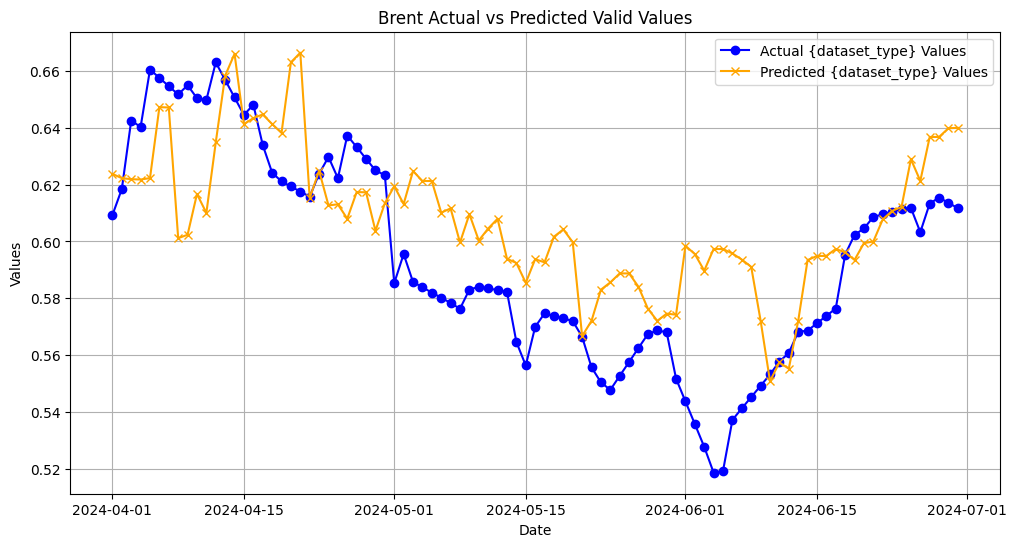

In [271]:
date = valid_df[['date']].reset_index(drop=True)
draw_accuracy_plot(date, y_Brent_valid, pd.Series(y_Brent_valid_pred, name="Predicted"), 'Brent', 'Valid')

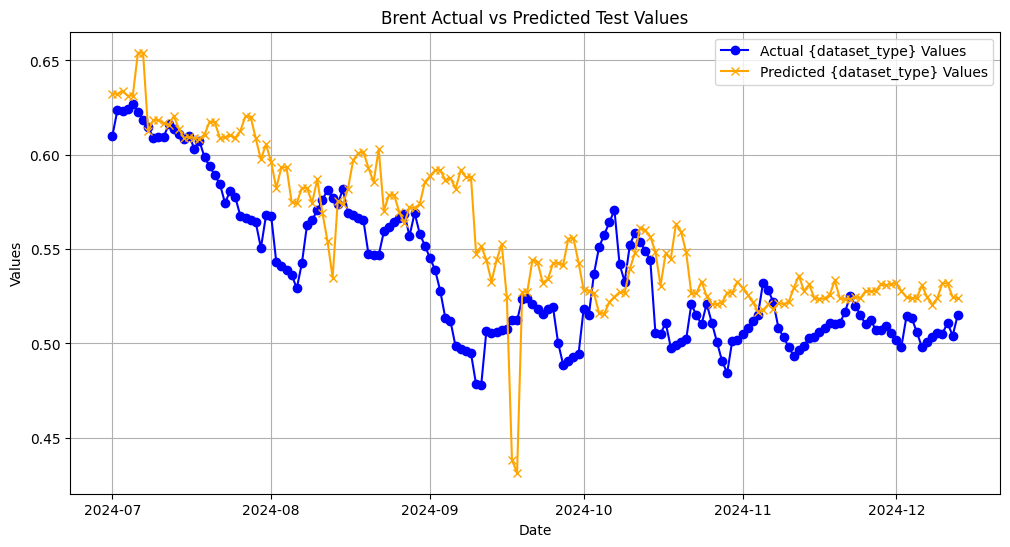

In [272]:
date = test_df[['date']].reset_index(drop=True)
draw_accuracy_plot(date, y_Brent_test, pd.Series(y_Brent_test_pred, name="Predicted"), 'Brent', 'Test')